<a href="https://colab.research.google.com/github/chorltonm/fa-cup-upsets/blob/main/notebooks/models/ml_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import general python libaries
import os
import json
import pandas as pd
import numpy as np
import importlib

# Google Cloud libraries
from google.cloud import bigquery
from google.oauth2 import service_account
from google.colab import drive
from google.colab import userdata
import pandas_gbq

# Scikit Learn libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Other
from matplotlib import pyplot
import seaborn as sns
from xgboost import XGBClassifier

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/python_files')



Mounted at /content/drive


In [ ]:
# Import user defined python functions
import model_evaluation_functions
importlib.reload(model_evaluation_functions)
from model_evaluation_functions import create_model_results_df

In [ ]:
# Authentication credentials and keys

# Google Service Account

# Load the JSON key from local Google Collab file
key = json.load(open('/content/drive/MyDrive/service_account.json', 'r'))

# Authenticate using the loaded key
credentials = service_account.Credentials.from_service_account_info(key)

# Set up the BigQuery client with the credentials to project
client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

In [ ]:
# Feature Data

fa_cup_raw_features = """
    SELECT * FROM preparation_layer.view_fa_cup_round_3_features WHERE season_year NOT IN ('21/22', '22/23')
"""

fa_cup_raw_features_df = client.query(fa_cup_raw_features).to_dataframe().drop(columns=['season_year'])
display(fa_cup_raw_features_df)


all_results_df = pd.DataFrame(columns=['metric_id', 'metric'])
display(all_results_df)


,arena_stadium_capacity,home_team_league_level,home_win,home_team_round_3_position,home_team_massey,home_team_colley,home_team_keener,home_team_trueskill,home_team_borda_count,home_team_local_kemeny_optimisation,...,match_weather_data_hours_dew,match_weather_data_hours_precip,match_weather_data_hours_snow,match_weather_data_hours_snowdepth,match_weather_data_hours_windspeed,match_weather_data_hours_pressure,match_weather_data_hours_visibility,match_weather_data_hours_cloudcover,match_weather_data_hours_condition,target_variable
0,41837,1,1,1,1,1,12,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0
1,41837,1,1,1,1,1,12,1,1,1,...,34.70,0.000,0.0,0.00,4.80,1036.70,2.05,95.90,Overcast,0
2,41837,1,1,1,1,1,12,1,1,1,...,47.00,0.000,0.0,0.00,2.10,1031.70,4.20,87.00,Partially cloudy,0
3,74879,1,1,1,1,1,12,1,1,1,...,71.20,0.000,NaN,0.00,7.65,1015.50,5.15,67.10,Partially cloudy,0
4,74879,1,0,2,3,7,4,6,4,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,<NA>,6,0,64,58,64,57,63,64,64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0
301,<NA>,6,0,64,58,64,57,63,64,64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0
302,9527,4,1,64,58,64,57,63,64,64,...,37.15,0.000,0.0,0.00,14.45,1012.75,9.00,94.25,Overcast Partially cloudy,1
303,6064,6,0,64,58,64,57,63,64,64,...,41.45,0.000,0.0,0.00,6.35,1036.35,15.15,98.65,Overcast,0


,metric_id,metric


In [ ]:
# Function to calculate home advantage
def add_home_advantage(X):

    result = X.groupby(['home_team_league_level', 'away_team_league_level'])['home_win'].mean().reset_index()
    result.columns = ['home_team_league_level', 'away_team_league_level', 'home_win_factor']
    result['home_win_factor'] = result['home_win_factor'].round(3)

    X = X.merge(result, on=['home_team_league_level', 'away_team_league_level'], how='left')
    return X, 'home_win_factor'

In [ ]:
# Function to calculate weights
def calculate_weights(y):
    class_counts = y.value_counts()
    total_samples = len(y)
    return {class_label: int(round((1 - (count / total_samples)) * 100))
            for class_label, count in class_counts.items()}


In [ ]:
# Function to run model classifiers
def classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state = 47):

  # Empty df for consolidating results
  all_results_df = pd.DataFrame(columns=['metric_id', 'metric'])
  fold_results = []

  # Define the ranking systems
  ranking_systems = ['no_ranking','round_3_position', 'massey', 'colley', 'keener', 'trueskill', 'borda_count', 'local_kemeny_optimisation']

  # Get all columns except the target and ranking columns
  target_variable = 'target_variable'
  base_features = [col for col in fa_cup_raw_features_df.columns if col != target_variable and not any(f"{team}_{ranking}" in col for team in ['home_team', 'away_team'] for ranking in ranking_systems)]

  # Identify numeric and categorical columns
  numeric_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
  categorical_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['object']).columns.tolist()

  # Define preprocessing steps

  numeric_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='median')),
      ('scaler', MinMaxScaler())
  ])

  categorical_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='most_frequent')),
      ('onehot', OneHotEncoder(handle_unknown='ignore'))
  ])

  ranking_transformer = Pipeline(steps=[
      ('scaler', MinMaxScaler())
  ])

  # Define cross-validation strategy
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

  # Loop through each ranking system
  for ranking in ranking_systems:
      model_name_ranking = f"{model_name} {ranking}"
      print(model_name_ranking)

      if ranking == 'no_ranking':
          # Use all base features without ranking
          X = fa_cup_raw_features_df[base_features]
      else:
          # Include ranking features
          current_features = base_features + [f'home_team_{ranking}', f'away_team_{ranking}']
          X = fa_cup_raw_features_df[current_features]

      y = fa_cup_raw_features_df['target_variable']

      # Initialize lists to store results for each fold of the model
      fold_accuracies = []
      fold_recalls = []
      confusion_matrices = []
      classification_reports = []
      all_y_true = []
      all_y_pred = []
      all_y_pred_proba = []  # Store probabilities for ROC

      # Perform cross-validation
      skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
      for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
          X_train, X_val = X.iloc[train_index], X.iloc[val_index]
          y_train, y_val = y.iloc[train_index], y.iloc[val_index]

           # Add home advantage if specified
          if home_advt == 'yes':
              X_train, home_advantage_column = add_home_advantage(X_train)
              X_val, _ = add_home_advantage(X_val)
              numeric_features = [home_advantage_column] + numeric_features

          # Update preprocessor
          if ranking == 'no_ranking':
              preprocessor = ColumnTransformer(
                  transformers=[
                      ('num', numeric_transformer, numeric_features),
                      ('cat', categorical_transformer, categorical_features)
                  ], verbose_feature_names_out=False)

          else:
              preprocessor = ColumnTransformer(
                  transformers=[
                      ('num', numeric_transformer, numeric_features),
                      ('cat', categorical_transformer, categorical_features),
                      ('rank', numeric_transformer, [f'home_team_{ranking}', f'away_team_{ranking}'])
                  ], verbose_feature_names_out=False)


          if weighted == 'yes':
             # Calculate weights using only training data
              weights = calculate_weights(y_train)
              print(f"Weights being used: {weights}")

          # Create pipeline
          pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model_classifier)
            ])

          # Create GridSearchCV object
          grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='recall', n_jobs=-1)

          # Fit GridSearchCV
          grid_search.fit(X_train, y_train)

          # Get best model
          best_model = grid_search.best_estimator_

          # Print the best recall from GridSearchCV
          print(f"Best parameters: {grid_search.best_params_}")
          print(f"Best Estimator's Recall (from GridSearchCV): {grid_search.best_score_:.3f}")

          # Make predictions
          y_pred = best_model.predict(X_val)
          y_pred_proba = best_model.predict_proba(X_val)[:, 1] # Probabilities for the positive class and ROC curve/AUC Score

          # Calculate accuracy
          accuracy = accuracy_score(y_val, y_pred)
          fold_accuracies.append(accuracy)

          # Calculate recall
          recall = recall_score(y_val, y_pred)
          fold_recalls.append(recall)

          # Store fold results
          fold_results.append({
              'Model Name Ranking': model_name_ranking,
              'Fold': fold,
              'Best Parameters (GridSearchCV)': grid_search.best_params_,
              'Best Recall (GridSearchCV)': grid_search.best_score_,
              'Validation Accuracy': accuracy,
              'Validation Recall': recall
          })

          # Confusion matrix
          cm = confusion_matrix(y_val, y_pred)
          confusion_matrices.append(cm)

          # Generate classification report
          cr = classification_report(y_val, y_pred, output_dict=True)
          classification_reports.append(cr)

          # Store true and predicted values for later analysis
          all_y_true.extend(y_val)
          all_y_pred.extend(y_pred)
          all_y_pred_proba.extend(y_pred_proba)

          print(f"Fold {fold} Accuracy: {accuracy:.3f}")
          print(f"Fold {fold} Recall: {recall:.3f}")

      # Calculate average accuracy
      avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
      print(f"Average Accuracy: {avg_accuracy:.3f}")

      # Calculate average recall
      avg_recall = sum(fold_recalls) / len(fold_recalls)
      print(f"Average Recall: {avg_recall:.3f}")

      # Create and display results using existing function
      results_df, cm_fig, roc_fig = create_model_results_df(all_y_true, all_y_pred, fold_accuracies, fold_recalls,  all_y_pred_proba, model_name_ranking)
      results_df = results_df.reset_index()
      results_df['metric_id'] = results_df.index + 1
      results_df = results_df[['metric_id', 'metric', model_name_ranking]]

      all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')

      fold_results_df = pd.DataFrame(fold_results)

  return all_results_df, fold_results_df

In [ ]:
# Standard, no weights
model_name = "Standard LogisticRegression"
home_advt = 'no'
weighted = 'no'
random_state = 47
model_classifier  = LogisticRegression(max_iter=1000)

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__C': np.logspace(-3, 3, 7),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
  }

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_slr = all_results_df
display(all_results_df_slr)

fold_results_df_slr = fold_results_df
display(fold_results_df_slr)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_slr.to_excel("all_slr_results.xlsx")
fold_results_df_slr.to_excel("fold_results_slr.xlsx")


Standard LogisticRegression no_ranking
Best parameters: {'classifier__C': 10.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.348
Fold 1 Accuracy: 0.705
Fold 1 Recall: 0.188
Best parameters: {'classifier__C': 1000.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.394
Fold 2 Accuracy: 0.639
Fold 2 Recall: 0.250
Best parameters: {'classifier__C': 100.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.348
Fold 3 Accuracy: 0.639
Fold 3 Recall: 0.188


KeyboardInterrupt: 

Standard LogisticRegression with home advantage no_ranking
Best parameters: {'classifier__C': 100.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.485
Fold 1 Accuracy: 0.689
Fold 1 Recall: 0.125
Best parameters: {'classifier__C': 100.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.455
Fold 2 Accuracy: 0.639
Fold 2 Recall: 0.250
Best parameters: {'classifier__C': 100.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.424
Fold 3 Accuracy: 0.656
Fold 3 Recall: 0.250
Best parameters: {'classifier__C': 10.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.443
Fold 4 Accuracy: 0.705
Fold 4 Recall: 0.235
Best parameters: {'classifier__C': 1000.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from G

,metric_id,metric,Standard LogisticRegression with home advantage no_ranking,Standard LogisticRegression with home advantage round_3_position,Standard LogisticRegression with home advantage massey,Standard LogisticRegression with home advantage colley,Standard LogisticRegression with home advantage keener,Standard LogisticRegression with home advantage trueskill,Standard LogisticRegression with home advantage borda_count,Standard LogisticRegression with home advantage local_kemeny_optimisation
0,1,Cross-validation Accuracy Mean,0.682,0.702,0.692,0.669,0.662,0.685,0.682,0.675
1,2,Cross-validation Accuracy Standard Deviation,0.030,0.026,0.028,0.050,0.043,0.028,0.045,0.051
2,3,Cross-validation Recall Mean,0.207,0.257,0.219,0.195,0.171,0.232,0.232,0.219
3,4,Cross-validation Recall Standard Deviation,0.030,0.026,0.028,0.050,0.043,0.028,0.045,0.051
4,5,Overall Accuracy,0.682,0.702,0.692,0.669,0.662,0.685,0.682,0.675
5,6,Confusion Matrix - True Negative (Class 0),191.000,193.000,193.000,188.000,188.000,190.000,189.000,188.000
6,7,Confusion Matrix - False Positive (Class 1),32.000,30.000,30.000,35.000,35.000,33.000,34.000,35.000
7,8,Confusion Matrix - False Negative (Class 0),65.000,61.000,64.000,66.000,68.000,63.000,63.000,64.000
8,9,Confusion Matrix - True Positive (Class 1),17.000,21.000,18.000,16.000,14.000,19.000,19.000,18.000
9,10,Precision (Class 0),0.746,0.760,0.751,0.740,0.734,0.751,0.750,0.746


,Model Name Ranking,Fold,Best Parameters (GridSearchCV),Best Recall (GridSearchCV),Validation Accuracy,Validation Recall
0,Standard LogisticRegression with home advantag...,1,"{'classifier__C': 100.0, 'classifier__penalty'...",0.484848,0.688525,0.125000
1,Standard LogisticRegression with home advantag...,2,"{'classifier__C': 100.0, 'classifier__penalty'...",0.454545,0.639344,0.250000
2,Standard LogisticRegression with home advantag...,3,"{'classifier__C': 100.0, 'classifier__penalty'...",0.424242,0.655738,0.250000
3,Standard LogisticRegression with home advantag...,4,"{'classifier__C': 10.0, 'classifier__penalty':...",0.443001,0.704918,0.235294
4,Standard LogisticRegression with home advantag...,5,"{'classifier__C': 1000.0, 'classifier__penalty...",0.459596,0.721311,0.176471
5,Standard LogisticRegression with home advantag...,1,"{'classifier__C': 100.0, 'classifier__penalty'...",0.515152,0.704918,0.250000
6,Standard LogisticRegression with home advantag...,2,"{'classifier__C': 1000.0, 'classifier__penalty...",0.469697,0.704918,0.312500
7,Standard LogisticRegression with home advantag...,3,"{'classifier__C': 100.0, 'classifier__penalty'...",0.439394,0.655738,0.250000
8,Standard LogisticRegression with home advantag...,4,"{'classifier__C': 10.0, 'classifier__penalty':...",0.427850,0.737705,0.235294
9,Standard LogisticRegression with home advantag...,5,"{'classifier__C': 1000.0, 'classifier__penalty...",0.507215,0.704918,0.235294


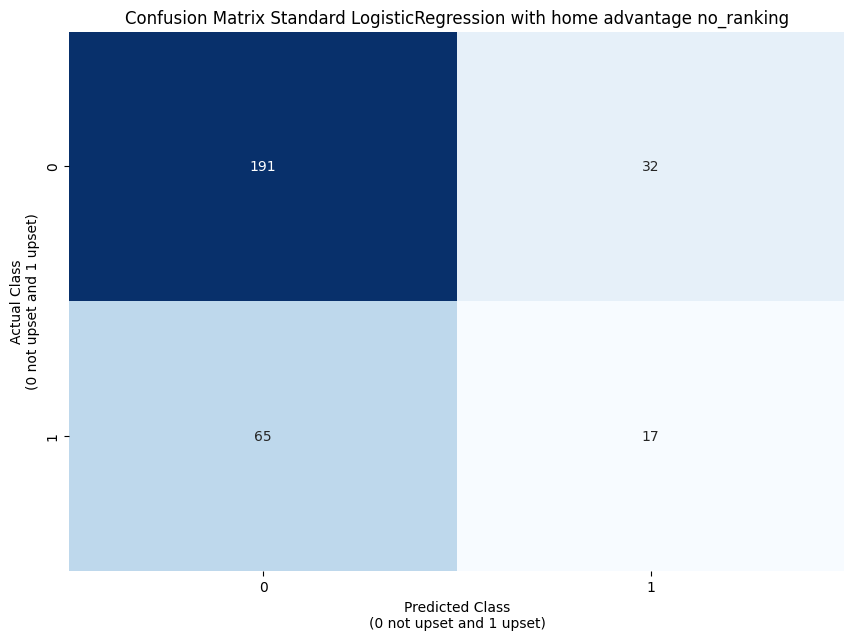

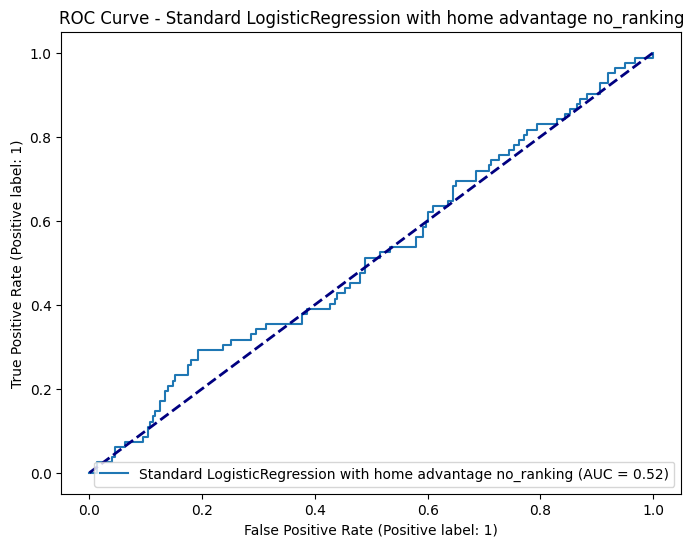

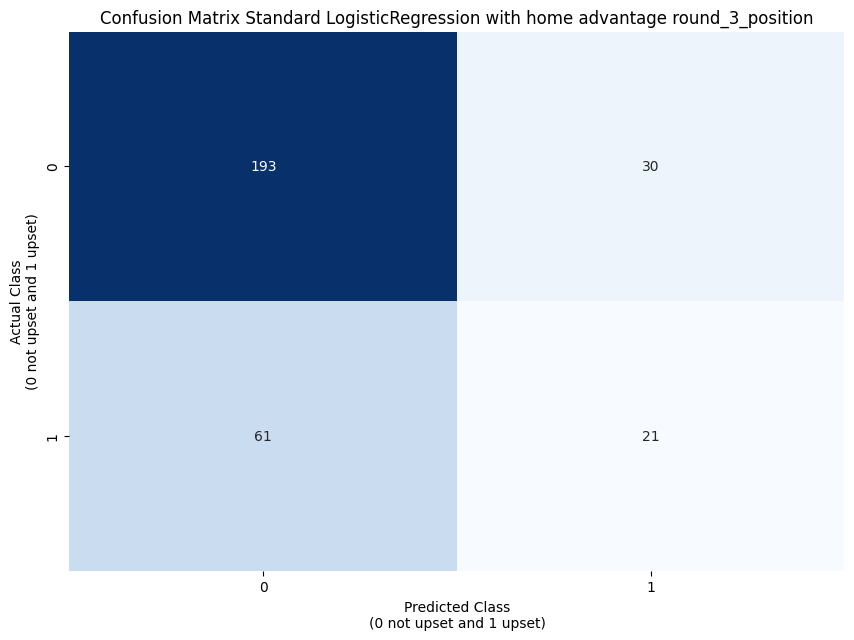

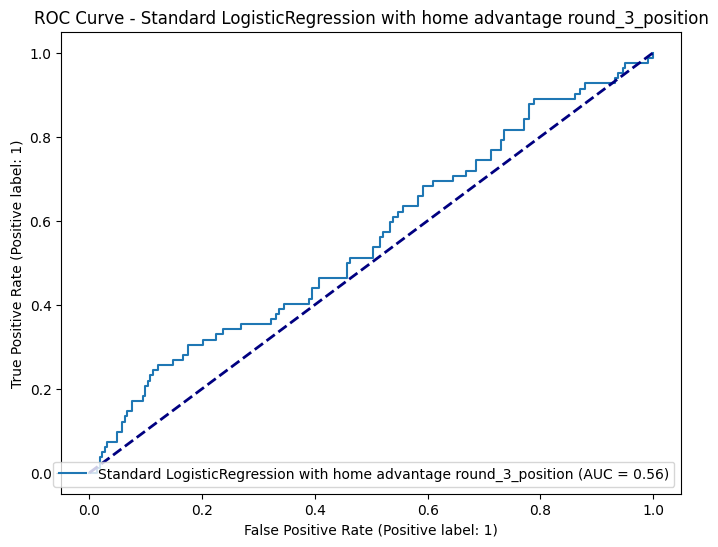

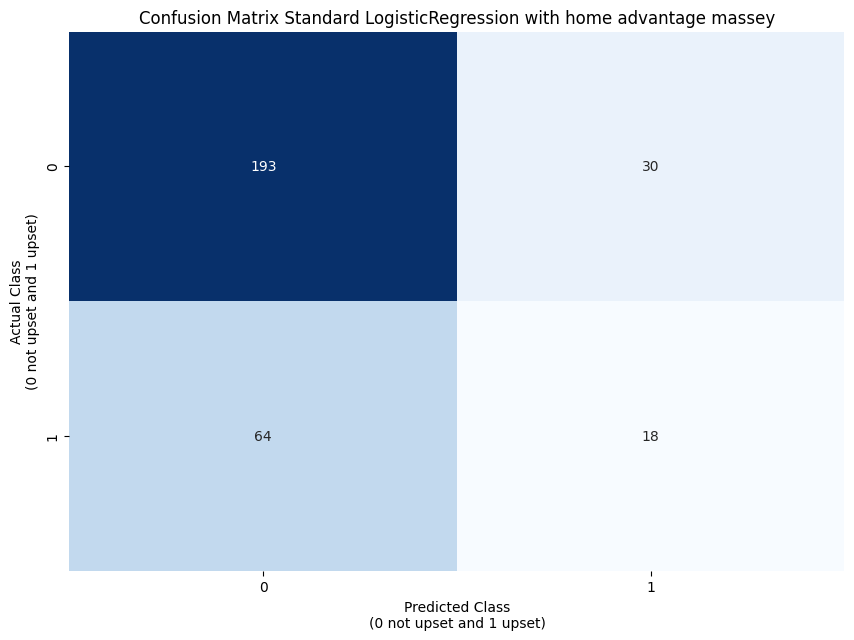

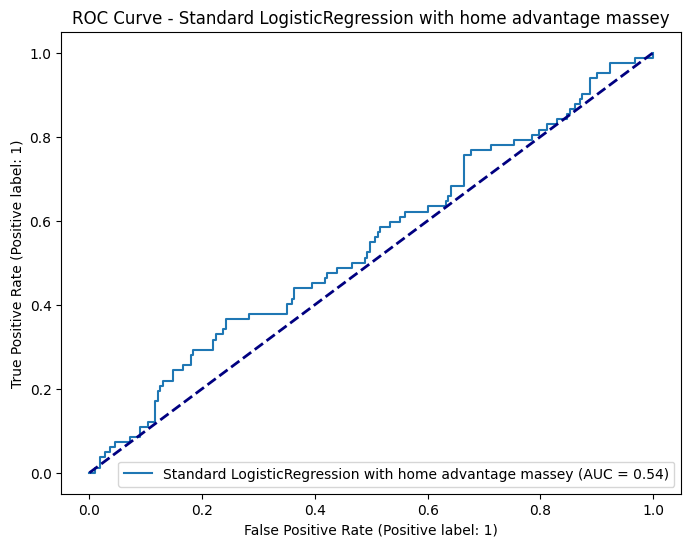

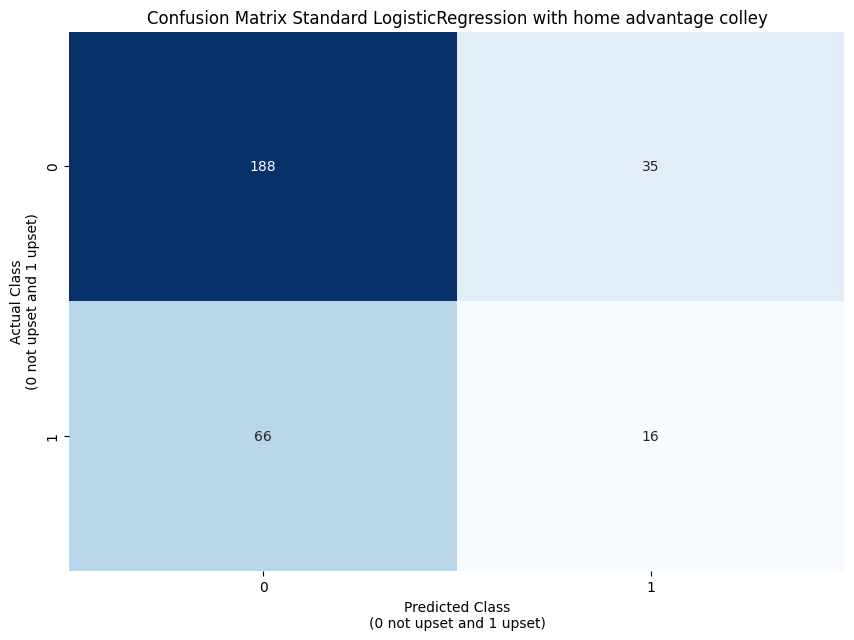

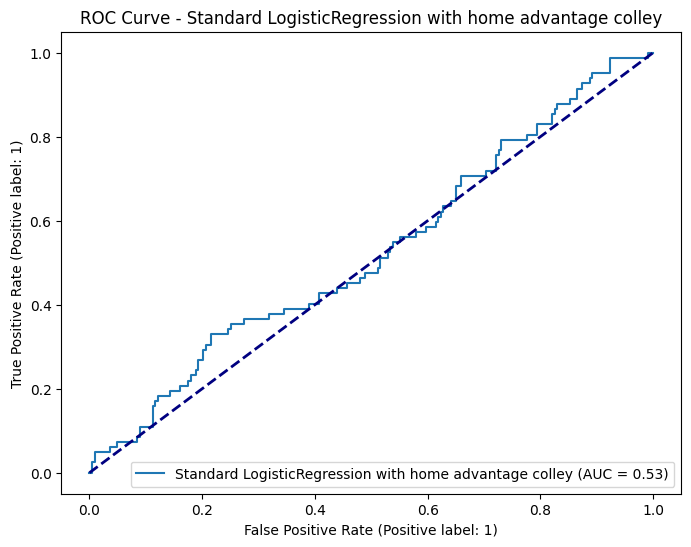

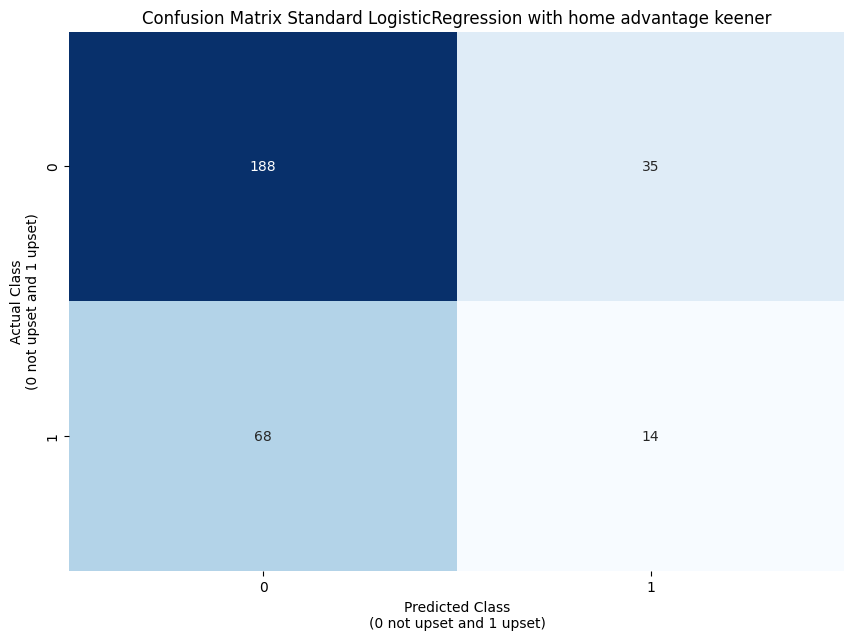

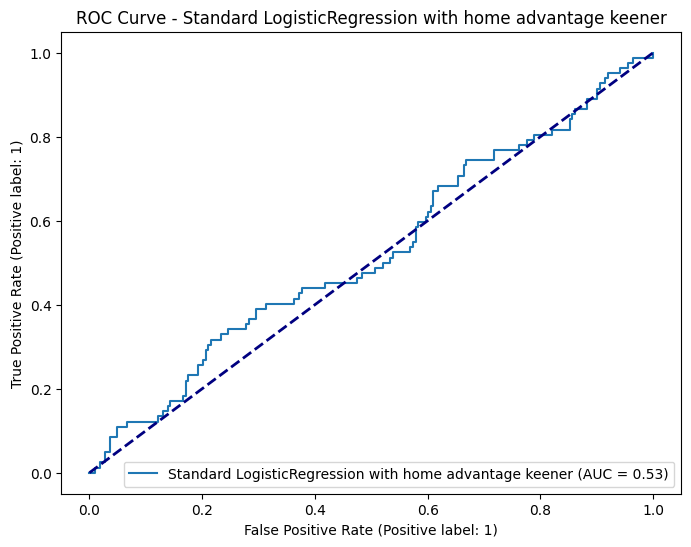

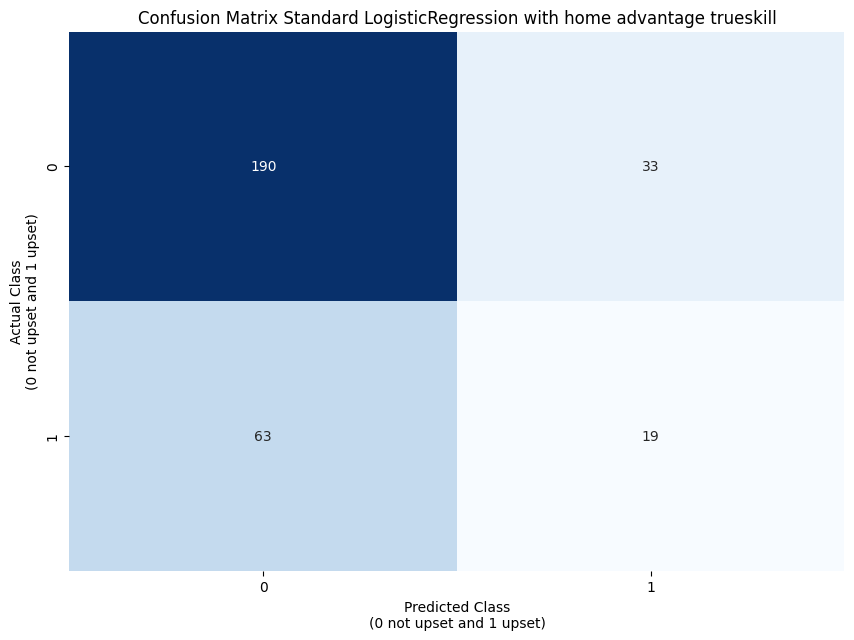

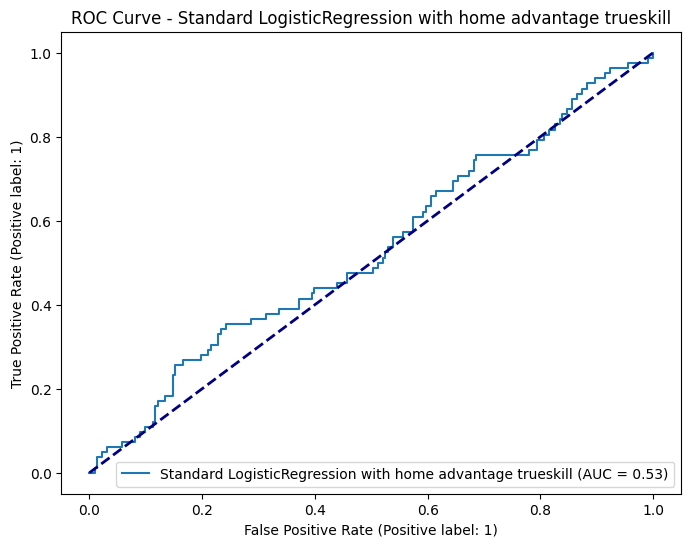

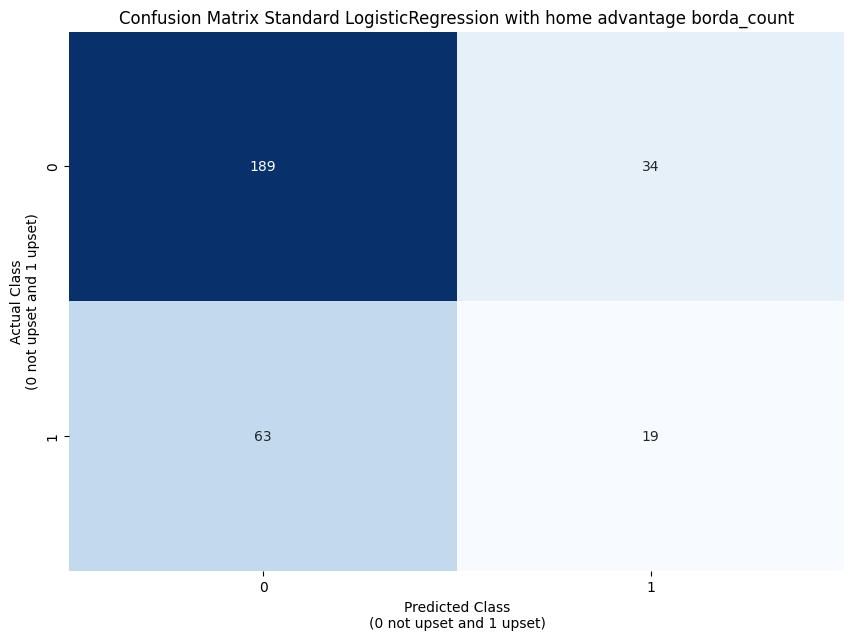

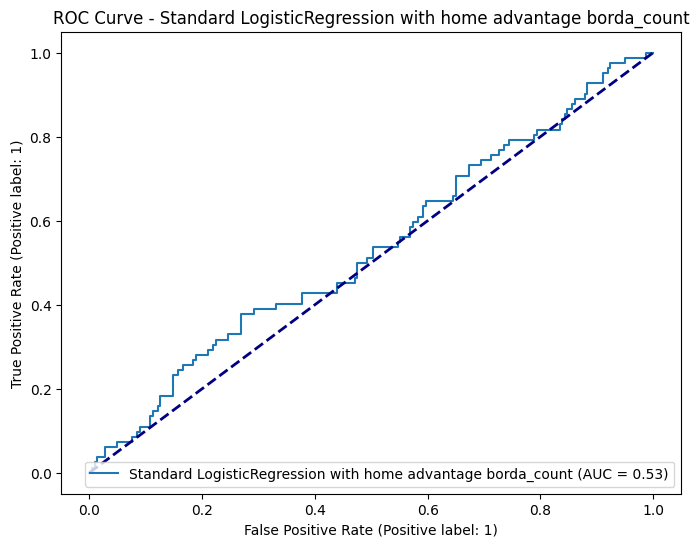

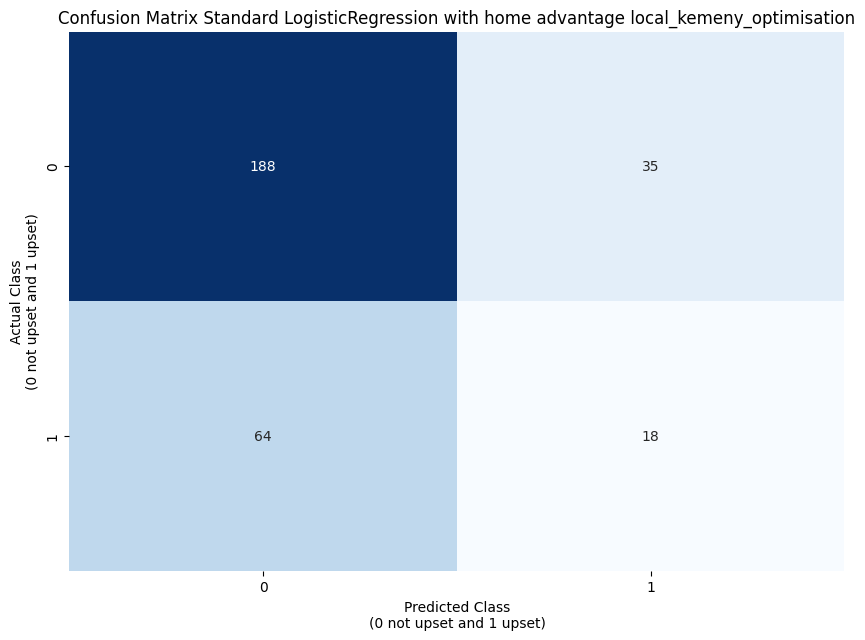

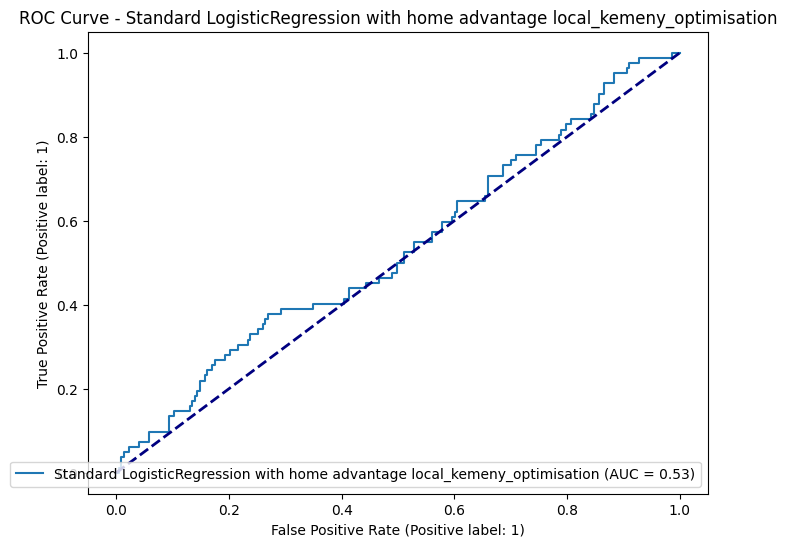

In [ ]:
# Standard, no weights with home advantage
model_name = "Standard LogisticRegression with home advantage"
home_advt = 'yes'
weighted = 'no'
random_state = 47
model_classifier  = LogisticRegression(max_iter=1000)

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__C': np.logspace(-3, 3, 7),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
  }

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_slrh = all_results_df
display(all_results_df_slrh)

fold_results_df_slrh = fold_results_df
display(fold_results_df_slrh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_slrh.to_excel("all_slrh_results.xlsx")
fold_results_df_slrh.to_excel("fold_results_slrh.xlsx")

Weighted LogisticRegression no_ranking
Weights being used: {0: 27, 1: 73}
Best parameters: {'classifier__C': 1.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.348
Fold 1 Accuracy: 0.721
Fold 1 Recall: 0.188
Weights being used: {0: 27, 1: 73}
Best parameters: {'classifier__C': 100.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.409
Fold 2 Accuracy: 0.639
Fold 2 Recall: 0.250
Weights being used: {0: 27, 1: 73}
Best parameters: {'classifier__C': 1.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.348
Fold 3 Accuracy: 0.607
Fold 3 Recall: 0.188
Weights being used: {0: 27, 1: 73}
Best parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.395
Fold 4 Accuracy: 0.672
Fold 4 Recall: 0.118
Weights being used: {0:

,metric_id,metric,Weighted LogisticRegression no_ranking,Weighted LogisticRegression round_3_position,Weighted LogisticRegression massey,Weighted LogisticRegression colley,Weighted LogisticRegression keener,Weighted LogisticRegression trueskill,Weighted LogisticRegression borda_count,Weighted LogisticRegression local_kemeny_optimisation
0,1,Cross-validation Accuracy Mean,0.672,0.698,0.689,0.669,0.666,0.675,0.679,0.679
1,2,Cross-validation Accuracy Standard Deviation,0.045,0.037,0.033,0.057,0.029,0.043,0.045,0.045
2,3,Cross-validation Recall Mean,0.184,0.257,0.208,0.196,0.160,0.208,0.208,0.208
3,4,Cross-validation Recall Standard Deviation,0.045,0.037,0.033,0.057,0.029,0.043,0.045,0.045
4,5,Overall Accuracy,0.672,0.698,0.689,0.669,0.666,0.675,0.679,0.679
5,6,Confusion Matrix - True Negative (Class 0),190.000,192.000,193.000,188.000,190.000,189.000,190.000,190.000
6,7,Confusion Matrix - False Positive (Class 1),33.000,31.000,30.000,35.000,33.000,34.000,33.000,33.000
7,8,Confusion Matrix - False Negative (Class 0),67.000,61.000,65.000,66.000,69.000,65.000,65.000,65.000
8,9,Confusion Matrix - True Positive (Class 1),15.000,21.000,17.000,16.000,13.000,17.000,17.000,17.000
9,10,Precision (Class 0),0.739,0.759,0.748,0.740,0.734,0.744,0.745,0.745


,Model Name Ranking,Fold,Best Parameters (GridSearchCV),Best Recall (GridSearchCV),Validation Accuracy,Validation Recall
0,Weighted LogisticRegression no_ranking,1,"{'classifier__C': 1.0, 'classifier__penalty': ...",0.348485,0.721311,0.187500
1,Weighted LogisticRegression no_ranking,2,"{'classifier__C': 100.0, 'classifier__penalty'...",0.409091,0.639344,0.250000
2,Weighted LogisticRegression no_ranking,3,"{'classifier__C': 1.0, 'classifier__penalty': ...",0.348485,0.606557,0.187500
3,Weighted LogisticRegression no_ranking,4,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.395382,0.672131,0.117647
4,Weighted LogisticRegression no_ranking,5,"{'classifier__C': 10.0, 'classifier__penalty':...",0.383117,0.721311,0.176471
5,Weighted LogisticRegression round_3_position,1,"{'classifier__C': 10.0, 'classifier__penalty':...",0.378788,0.721311,0.250000
6,Weighted LogisticRegression round_3_position,2,"{'classifier__C': 1.0, 'classifier__penalty': ...",0.424242,0.672131,0.312500
7,Weighted LogisticRegression round_3_position,3,"{'classifier__C': 1.0, 'classifier__penalty': ...",0.393939,0.639344,0.250000
8,Weighted LogisticRegression round_3_position,4,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.380952,0.737705,0.235294
9,Weighted LogisticRegression round_3_position,5,"{'classifier__C': 10.0, 'classifier__penalty':...",0.476912,0.721311,0.235294


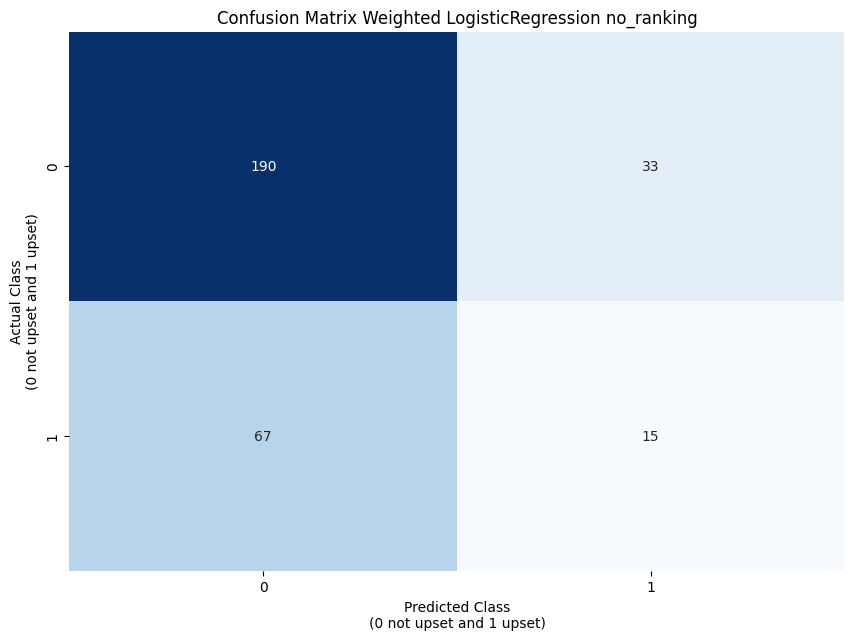

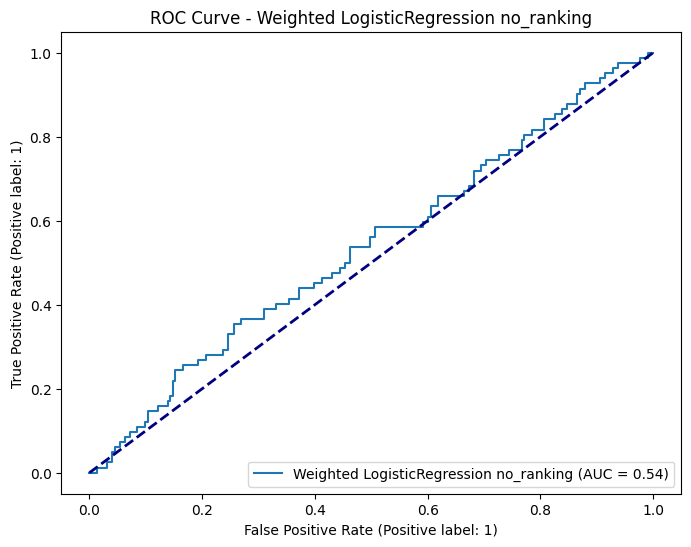

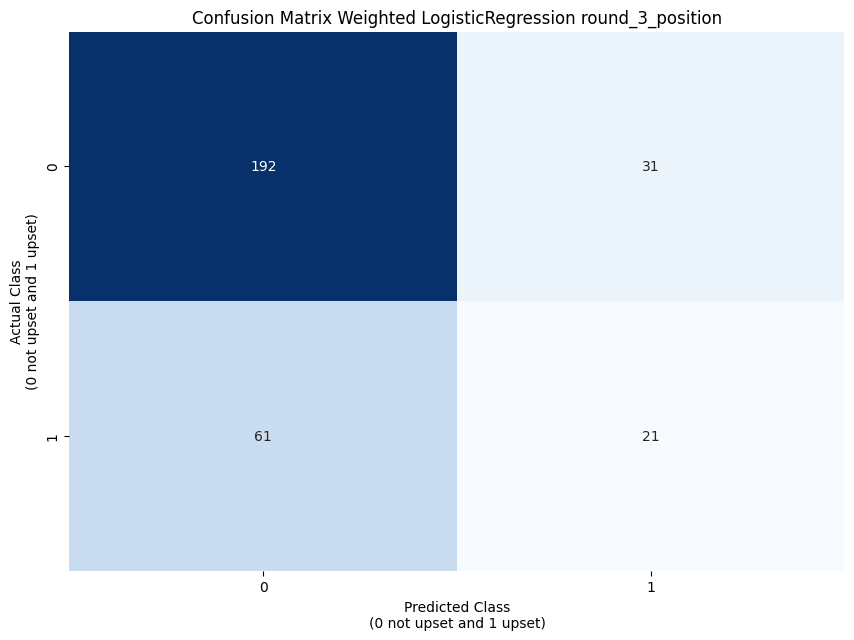

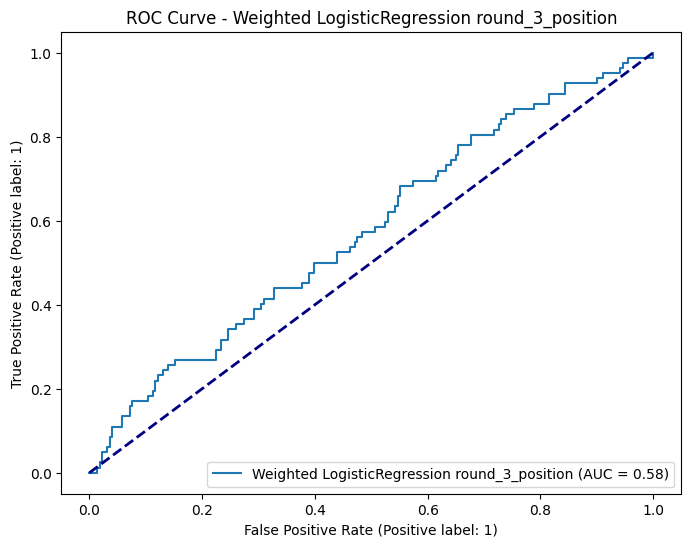

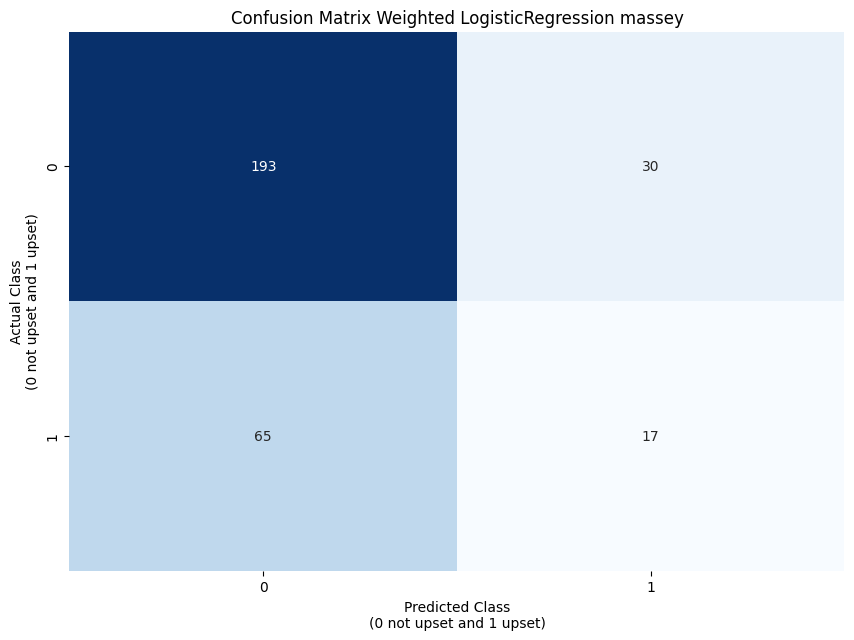

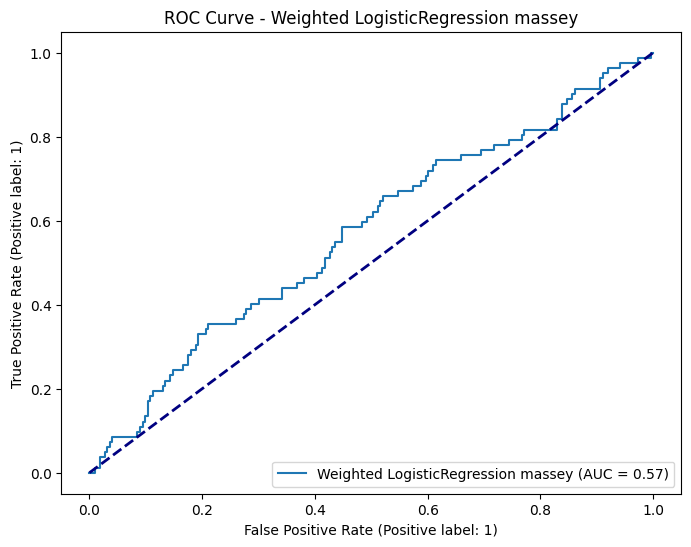

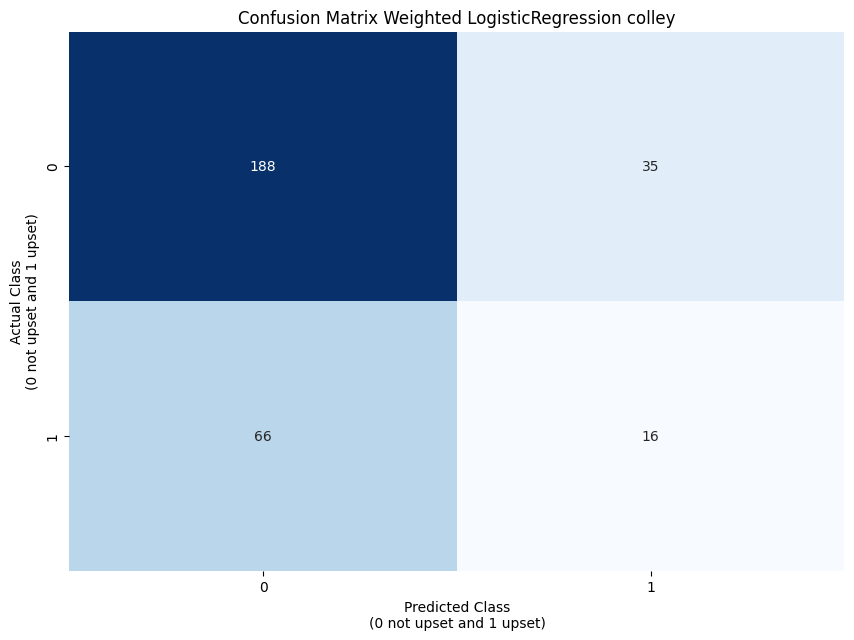

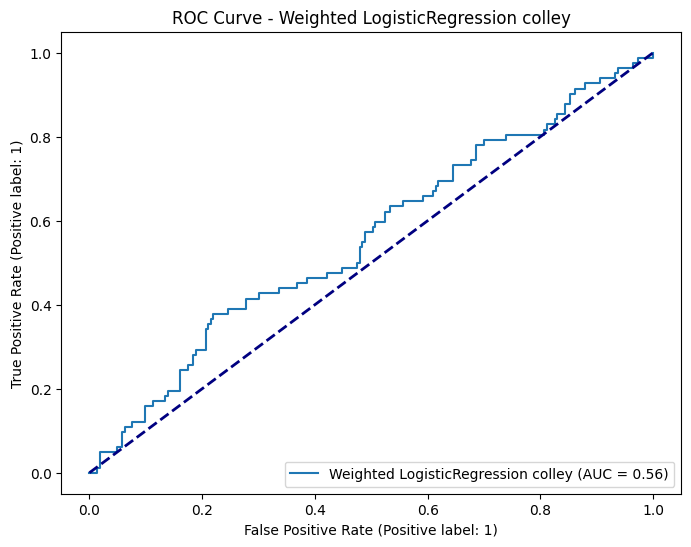

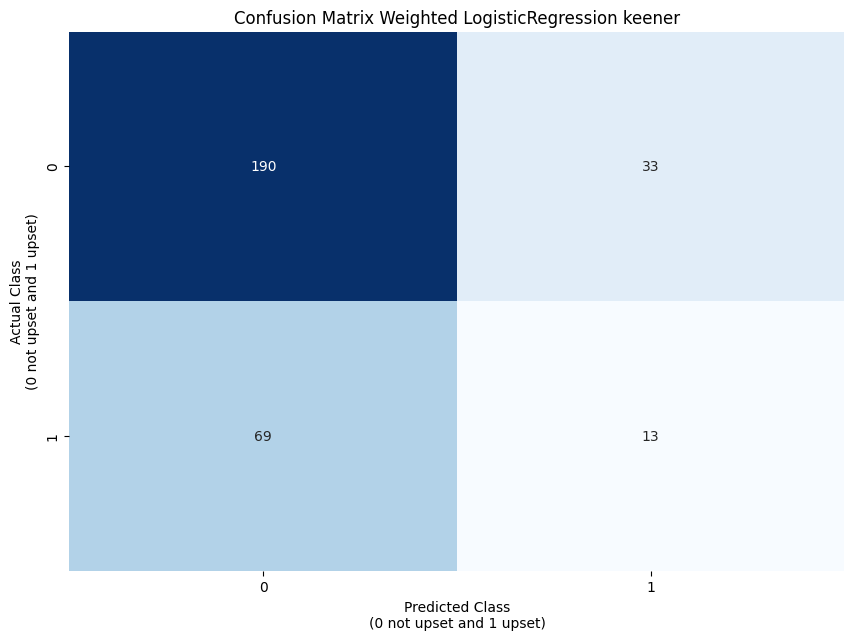

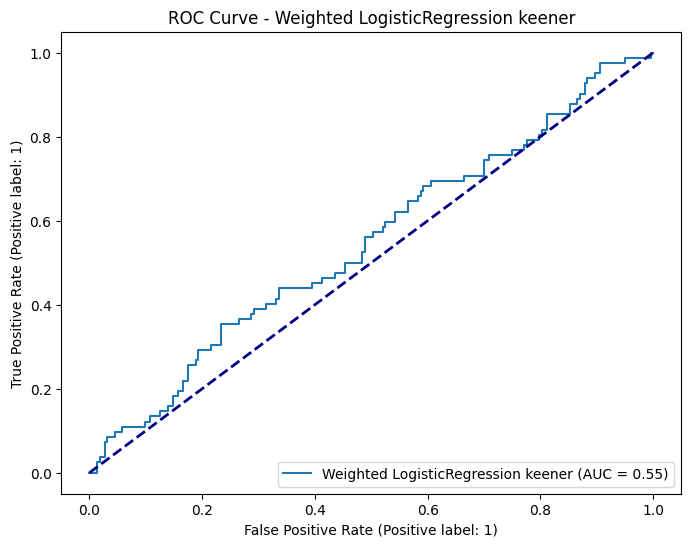

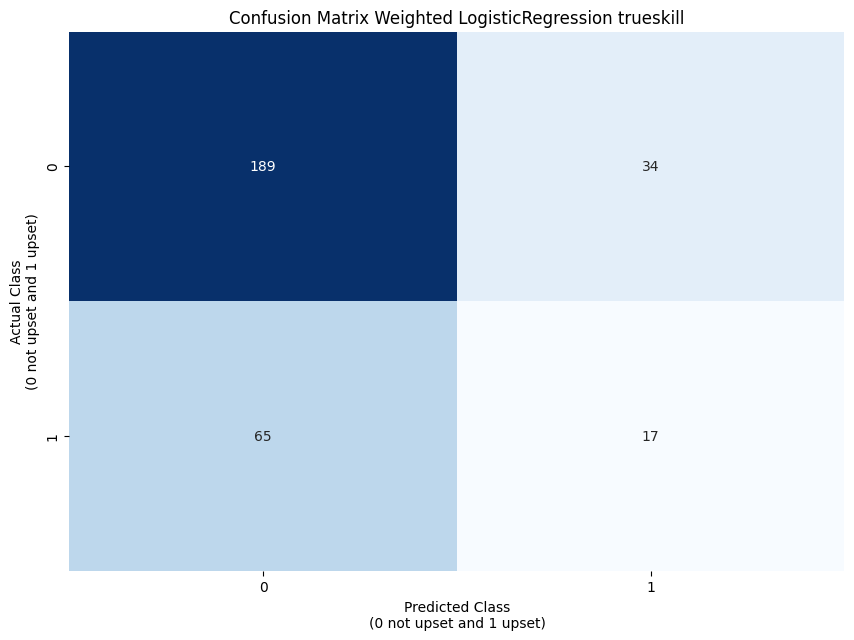

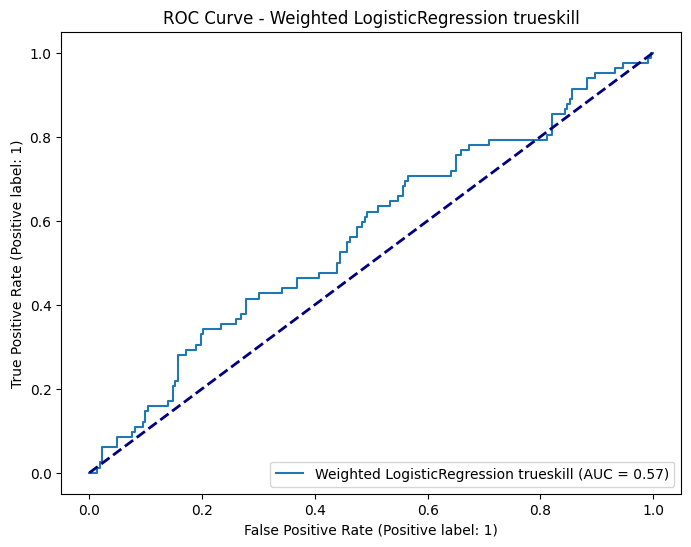

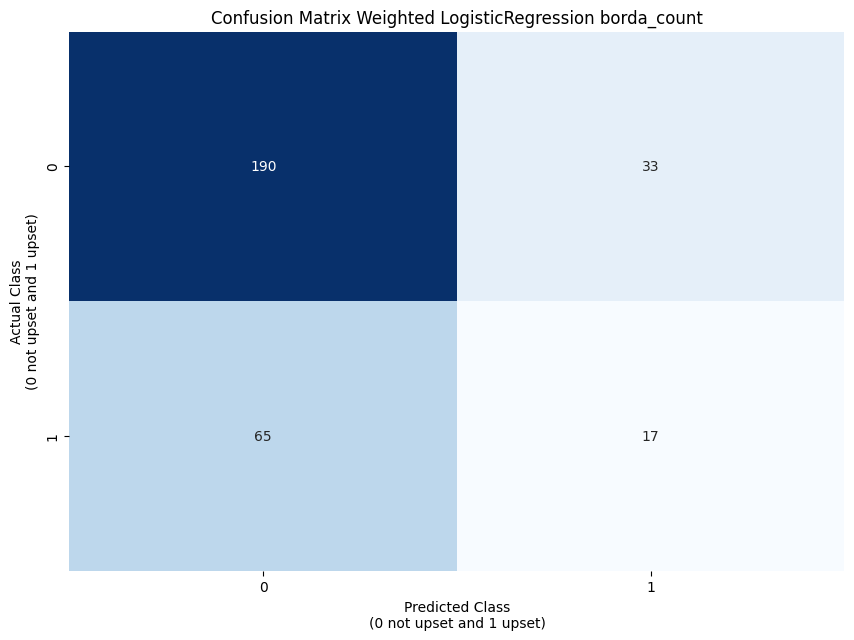

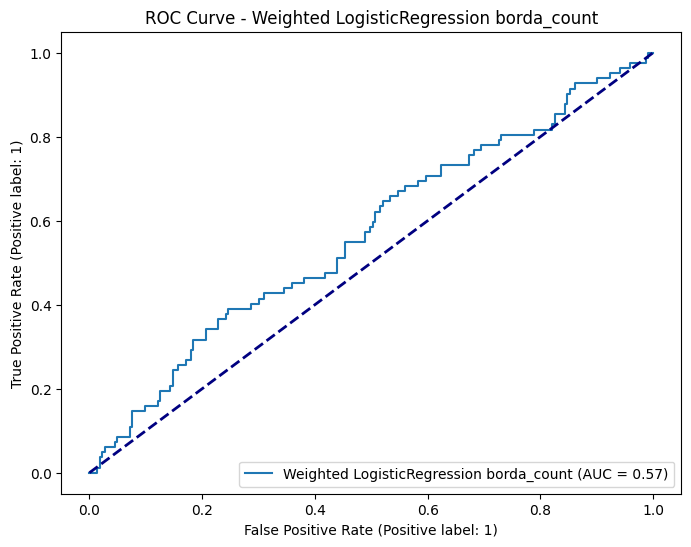

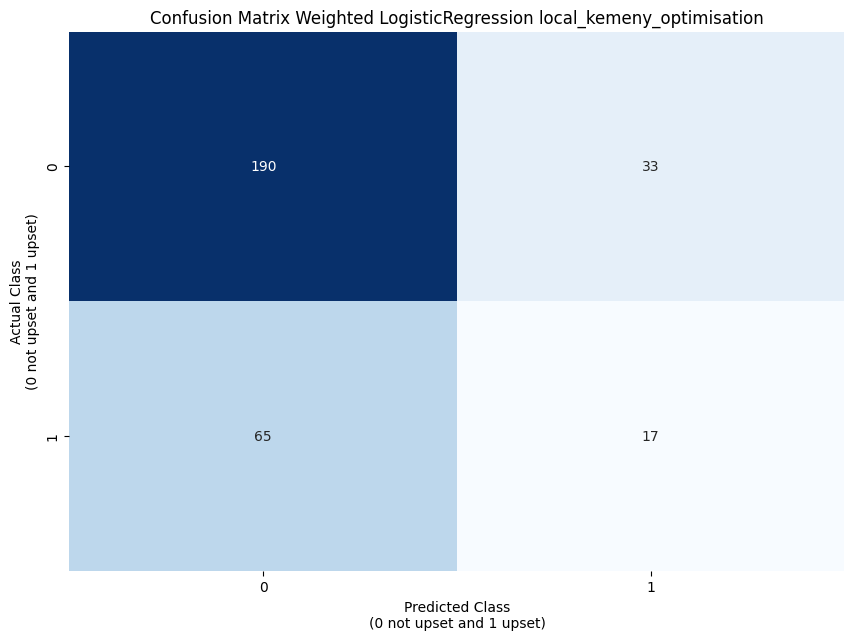

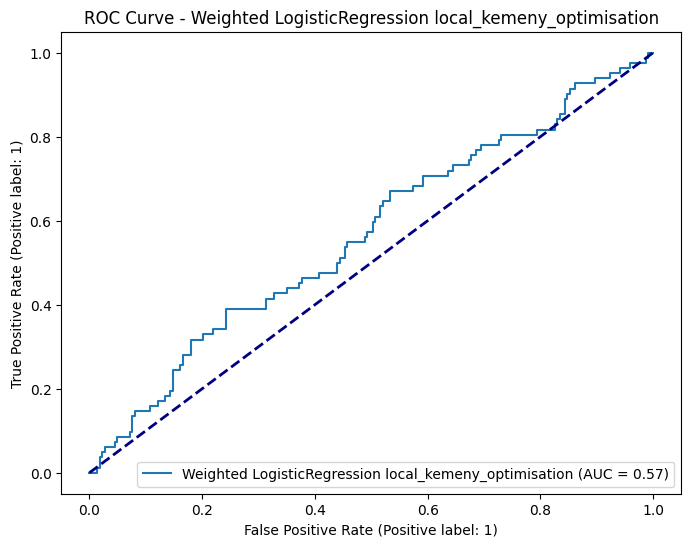

In [ ]:
0# Weighted Logistc Regression
model_name = "Weighted LogisticRegression"
home_advt = 'no'
weighted = 'yes'
random_state = 47
weights = {0: 50, 1: 50} # intial value before recalauclating
model_classifier  = LogisticRegression(class_weight=weights, max_iter=1000)

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__C': np.logspace(-3, 3, 7),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
  }

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_wlr = all_results_df
display(all_results_df_wlr)

fold_results_df_wlr = fold_results_df
display(fold_results_df_wlr)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_wlr.to_excel("all_wlr_results.xlsx")
fold_results_df_wlr.to_excel("fold_results_wlr.xlsx")

In [ ]:
# Weighted Logistc Regression with home advatange
model_name = "Weighted LogisticRegression with home advantage"
home_advt = 'yes'
weighted = 'yes'
random_state = 47
model_classifier  = LogisticRegression(class_weight=weights, max_iter=1000)

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__C': np.logspace(-3, 3, 7),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
  }

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_wlrh = all_results_df
display(all_results_df_wlrh)

fold_results_df_wlrh = fold_results_df
display(fold_results_df_wlrh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_wlrh.to_excel("all_wlrh_results.xlsx")
fold_results_df_wlrh.to_excel("fold_results_wlrh.xlsx")

In [ ]:
# MCP Neural Network
model_name = "MLP Classifier Neural Network"
home_advt = 'no'
weighted = 'no'
max_iter = 10000
random_state = 47
model_classifier  = MLPClassifier()

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__max_iter': [max_iter],
    'classifier__random_state': [random_state],
    'classifier__hidden_layer_sizes': [(10,10,10), (20,20,), (10,)],
    'classifier__activation': ['logistic', 'tanh', 'relu'],
    'classifier__learning_rate_init': [0.001, 0.01, 0.1],
  }

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_nn = all_results_df
display(all_results_df_nn)

fold_results_df_nn = fold_results_df
display(fold_results_df_nn)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_nn.to_excel("all_nn_results.xlsx")
fold_results_df_nn.to_excel("fold_results_nn.xlsx")

In [ ]:
# MCP Neural Network
model_name = "MLP Classifier Neural Network with home advantage"
home_advt = 'yes'
weighted = 'no'
max_iter = 10000
random_state = 47
model_classifier  = MLPClassifier()

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__max_iter': [max_iter],
    'classifier__random_state': [random_state],
    'classifier__hidden_layer_sizes': [(10,10,10), (20,20,), (10,)],
    'classifier__activation': ['logistic', 'tanh', 'relu'],
    'classifier__learning_rate_init': [0.001, 0.01, 0.1],
  }

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_nnh = all_results_df
display(all_results_df_nnh)

fold_results_df_nnh = fold_results_df
display(fold_results_df_nnh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_nnh.to_excel("all_nnh_results.xlsx")
fold_results_df_nnh.to_excel("fold_results_nnh.xlsx")

In [ ]:
# Random Forest Classifier
model_name = "Random Forest Classifier"
home_advt = 'no'
weighted = 'no'
random_state = 47
model_classifier  = RandomForestClassifier()

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__random_state': [random_state],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': [ None, 'sqrt']
}

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_rf = all_results_df
display(all_results_df_rf)

fold_results_df_rf = fold_results_df
display(fold_results_df_rf)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_rf.to_excel("all_rf_results.xlsx")
fold_results_df_rf.to_excel("fold_results_rf.xlsx")


In [ ]:
# Random Forest Classifier with home advantage
model_name = "Random Forest Classifier with home advantage"
home_advt = 'yes'
weighted = 'no'
random_state = 47
model_classifier  = RandomForestClassifier()

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__random_state': [random_state],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': [ None, 'sqrt']
}

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_rf = all_results_df
display(all_results_df_rf)

fold_results_df_rf = fold_results_df
display(fold_results_df_rf)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_rf.to_excel("all_rf_results.xlsx")
fold_results_df_rf.to_excel("fold_results_rf.xlsx")

In [ ]:
# XG Boost
model_name = "XG Boost"
home_advt = 'no'
weighted = 'no'
random_state = 47
model_classifier  = XGBClassifier()

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__random_state': [random_state],
    'classifier__max_depth': [3,5],
    'classifier__min_child_weight': [1, 2],
    'classifier__subsample': [ 0.8, 1.0],
    'classifier__colsample_bytree': [ 0.6, 1.0],
    'classifier__learning_rate':  [0.01, 0.1]
}

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_xg = all_results_df
display(all_results_df_xg)

fold_results_df_xg = fold_results_df
display(fold_results_df_xg)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_xg.to_excel("all_xg_results.xlsx")
fold_results_df_xg.to_excel("fold_results_xg.xlsx")

In [ ]:
# XG Boost with home advantage
model_name = "XG Boost with home advantage"
home_advt = 'yes'
weighted = 'no'
random_state = 47
model_classifier  = XGBClassifier()

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__random_state': [random_state],
    'classifier__max_depth': [3,5],
    'classifier__min_child_weight': [1, 2],
    'classifier__subsample': [ 0.8, 1.0],
    'classifier__colsample_bytree': [ 0.6, 1.0],
    'classifier__learning_rate':  [0.01, 0.1]
}

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_xgh = all_results_df
display(all_results_df_xgh)

fold_results_df_xgh = fold_results_df
display(fold_results_df_xgh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_xgh.to_excel("all_xgh_results.xlsx")
fold_results_df_xgh.to_excel("fold_results_xgh.xlsx")

In [ ]:
all_results_df = all_results_df_slrh.merge(all_results_df_slr, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_wlr.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_wlrh.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_nn.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_nnh.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_rf.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
#all_results_df = all_results_df_rfh.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_xg.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
#all_results_df = all_results_df_xgh.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

In [ ]:
# Load updated Confusion Matrix results to Google Big Query
load_dataset_name = 'analysis_layer'
load_table_name = 'ml_model_confusion_matrix_results'
full_table_name = f"{load_dataset_name}.{load_table_name}"
pandas_gbq.to_gbq(all_results_df, full_table_name, project_id='birkbeck-msc-project-422917', if_exists='replace')

In [ ]:
fold_results_df = pd.concat([fold_results_df_slr, fold_results_df_slrh, fold_results_df_wlrh, fold_results_df_nn, fold_results_df_nnh, fold_results_df_rf, fold_results_df_rfh, fold_results_df_xg, fold_results_df_xgh])
display(fold_results_df)

In [ ]:
# Load updated Confusion Matrix results to Google Big Query
load_dataset_name = 'analysis_layer'
load_table_name = 'ml_model_fold_results'
full_table_name = f"{load_dataset_name}.{load_table_name}"
pandas_gbq.to_gbq(fold_results_df, full_table_name, project_id='birkbeck-msc-project-422917', if_exists='replace')